# Exploring data

Firstly, we will need to carefully study the dataset that will be used to solve the classification problem. To do this, we will load the necessary libraries and import data structures and functions which will be particularly useful in data analysis, data vizualization and preparation and training machine learning models. 

Additionally, let's define the following constants:

* `TRAIN_SET_SHARE` => Share of training set;
* `TEST_SET_SHARE` => Share of test set; 
* `RANDOM_STATE` => Pseudo random number generator state;
* `ACCURACY_THRESHOLD` => Accuracy threshold that the final model needs to surpass on the test set;
* `CV_INNER` => Folds for nested crossvalidation in the inner loop;
* `CV_OUTER` => Folds for nested crossvalidation in the outer loop;
* `SCORER` => Metric used during crossvalidation.

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from joblib import dump
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    LearningCurveDisplay,
    RandomizedSearchCV,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

ACCURACY_THRESHOLD = 0.75
CV_INNER = 2
CV_OUTER = 5
RANDOM_STATE = 12345
SCORER = "accuracy"
TEST_SET_SHARE = 0.3
TRAIN_SET_SHARE = 0.7

Now, after getting access to `pandas` library for data analysis, we will use the `read_csv()` function to load the dataset to a DataFrame object - `users_data`.

In [2]:
users_data = pd.read_csv("datasets/users_behavior.csv")

Let's display random ten rows of the DataFrame contained in `users_data` variable and consider the information shown. In order to make the result reproducible, we will fix the state of the preudo random number generator using `RANDOM_STATE` value.

In [3]:
display(users_data.sample(n=10, random_state=RANDOM_STATE))

,calls,minutes,messages,mb_used,is_ultra
1415,82.0,507.89,88.0,17543.37,1
916,50.0,375.91,35.0,12388.40,0
1670,83.0,540.49,41.0,9127.74,0
686,79.0,562.99,19.0,25508.19,1
2951,78.0,531.29,20.0,9217.25,0
654,53.0,478.18,78.0,20152.53,0
2827,73.0,582.47,33.0,12095.91,0
1466,31.0,172.10,25.0,31077.59,0
2223,28.0,222.21,30.0,22986.30,0
2639,68.0,523.56,14.0,18910.66,0


In [4]:
# Counting unique values of each class in target
users_data["is_ultra"].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

We can see that the data seems to be already preprocessed, where we have 4 features expressed by `calls`, `minutes`, `messages` and `mb_used` columns as well as one binary target variable - `is_ultra`. In this case, we will solve the binary classification problem with two classes so at first sight the target is seen to be encoded correctly. Nevertheless, let's take a closer look at the DataFrame and output a concise summary of it using the `info()` method.

In [5]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


We observe the following. The table contains data on 3,214 customers of a mobile operator that are characterized by five columns: four features and one target. The features are numeric and have `float64` data type, while the target variable is binary and is therefore expressed by the integer type - `int64`. The number of non-null values is equal across DataFrame columns and are equal to the total number of objects in the dataset, which indicates the absence of missing values. Let's take a closer look at what information the columns contain:

<table>
<thead>
<tr><th>Features</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><code>calls</code></td><td><i>Number of calls</i></td></tr>
<tr><td><code>minutes</code></td><td><i>Total duration of calls (minutes)</i></td></tr>
<tr><td><code>messages</code></td><td><i>Number of SMS messages</i></td></tr>
<tr><td><code>mb_used</code></td><td><i>Internet traffic used (MB)</i></td></tr>
<tr><td><code>is_ultra</code></td><td><i>Indicator of the customer's tariff ({1: "Ultra", 0: "Smart"})</i></td></tr>
</tbody>
</table>

It seems that data preprocessing will not be required: there are no missing values in this dataset. However, it is worth converting data types in the `calls` and `messages` columns, since the numbers of calls and SMS messages cannot be fractional. This will not affect the results of the study but, nevertheless, the features should be characterized by correct data types.

In [6]:
# Conversion to int64
users_data["calls"] = users_data["calls"].astype("int64")
users_data["messages"] = users_data["messages"].astype("int64")

Now, let's look at the first five rows of the DataFrame and print a summary of it in order to check whether the changes made were actually carried out.

In [7]:
display(users_data.head())

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


In [8]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


It can be seen that the data has been properly tranformed and can be used in the machine learning process. Before proceeding to dividing the dataset into sets, let's look at the distribution of values in each feature column and how they are scattered relative to one another, depending on tariff. 

We will make use of `pairplot` function of `seaborn` library which will produce a matrix-like plot of pairwise numeric relationships in the dataset. The main diagonal will contain histograms of each numeric feature, while off-diagonal elements will depict scatterplots of each pair of variables depending on the value of the target variable `is_ultra` which we include in `hue` parameter. Moreover, such a plot will help us to consider how observations pertaining to a certain class look like using different numeric features as axes.

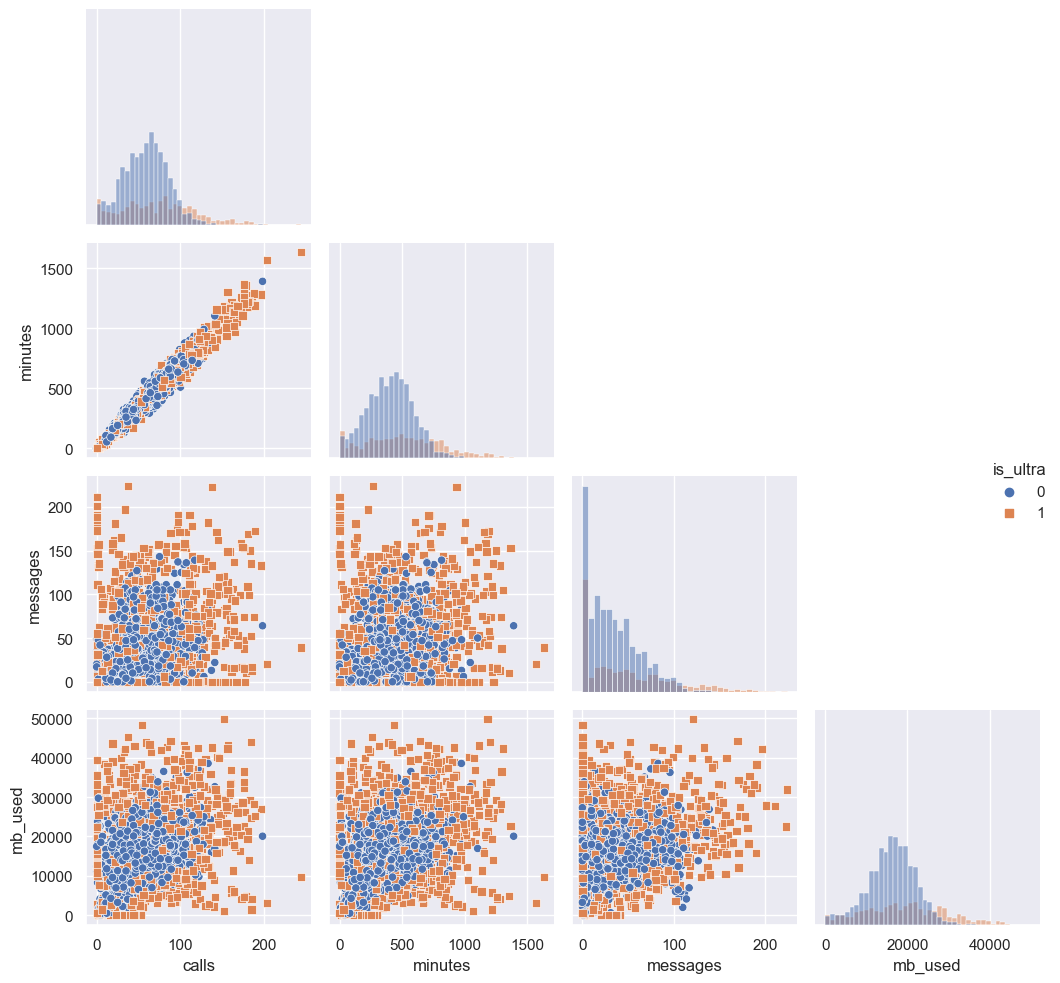

In [9]:
# Setting style for plots
sns.set_theme(style="darkgrid")

# Plotting histograms and scatterplots for features
sns.pairplot(
    data=users_data, hue="is_ultra", diag_kind="hist", corner="true", markers=["o", "s"]
)
plt.tight_layout()
plt.show()

We can notice the following peculiarities of the data:
    
    1. The data is seen to be characterized by classes that seem to be linearly unseparable. In this case algorithms making use of kernel methods (Support Vector, for instance) can be worth considering.
    
    2. Users enjoying "Ultra" tariff are generally characterized by higher numbers of calls made and messages sent as well as a larger amount of internet traffic spent. This is the result of more favorable terms of this tariff which is more expensive but provides more features.

    3. In some cases users with "Smart" tariff spend more time on calls/messages/internet but on rare ocassions.
    
    4. By looking at histograms we can also notice that since there are more clients of "Smart" tariff histogram bins for these users tend to be larger.
    
    5. The distribution of features resembles a normal distribution but a rightly skewed one, with the messages sent being the most vivid example.

Finally, we can plot the numeric structure of the target variable.

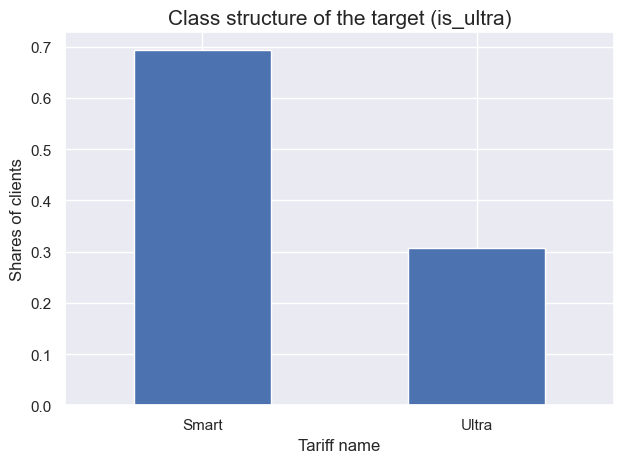

In [10]:
# Plotting a histogram for a target
users_data["is_ultra"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Tariff name",
    ylabel="Shares of clients",
)
plt.xticks(ticks=[0, 1], labels=["Smart", "Ultra"], rotation=0)
plt.title("Class structure of the target (is_ultra)", fontsize=15)
plt.tight_layout()
plt.show()

As far as the target variable is concerned, we see that the classes are imbalanced: the dataset contains more clients with "Smart" tariff rather than with "Ultra". In other words, the target variable is imbalanced: we observe the following proportions of class labels: 70% of "Smart" users and 30% of "Ultra" users. This may create some problems for the models to correctly classify users into groups.

**Conclusion**

At this preliminary stage, the data has been studied and visualized. We have noticed interesting patterns in the data by plotting `pairplot` of the DataFrame. We have also managed to identify the imbalance of classes in the data.

# Training, validation and test sets

The data is ready for machine learning. Before dividing the data into data sets, we will need to separate the features from the target variable and save them into separate variables as NumPy arrays.

In [11]:
# Retrieving features
features = users_data.drop(["is_ultra"], axis=1).values

# Singling out a target vector
target = users_data["is_ultra"].values

Now, we can easily split the data into training and test sets using `train_test_split` function from `sklearn.model_selection` submodule. We have assigned 0.3 to `TEST_SET_SHARE` constant at the beginning so by setting it to `test_size` parameter we assign random 30% of the data to the test set. Providing `target` as an argument to `stratify` ensures that both training and test datasets will have the same class proportions as the original dataset. Moreover, by passing `RANDOM_STATE` to `random_state` we will make sure that the same DataFrame indices are assigned to training and test sets for reproducibility.

In [12]:
# Splitting data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=TEST_SET_SHARE,
    stratify=target,
    random_state=RANDOM_STATE,
)

Lastly, let's check if the shares of sets are as per those defined above.

In [13]:
# Computing shares of training features and training target
features_train_share = np.round(features_train.shape[0] / users_data.shape[0], 2)
target_train_share = np.round(target_train.shape[0] / users_data.shape[0], 2)

# Computing shares of testing features and testing target
features_test_share = np.round(features_test.shape[0] / users_data.shape[0], 2)
target_test_share = np.round(target_test.shape[0] / users_data.shape[0], 2)

# Making sure that the set shares are correct
assert (
    features_train_share == target_train_share == TRAIN_SET_SHARE
), "Train set shares inconsistency"
assert (
    features_test_share == target_test_share == TEST_SET_SHARE
), "Test set share inconsistency"

**Conclusion**

This intermediate stage allowed for the final preparation of data for their use in classification algorithms. The DataFrame has been divided into training and test test in the proportion of 70-30. Moreover, the correctness of the data splitting was checked manually, which enables moving on to training machine learning models.

# Training models

**Classification models:**

* *Decision Tree* => `DecisionTreeClassifier`
* *Random Forest* => `RandomForestClassifier`
* *Logistic Regression* => `LogisticRegression`
* *Support Vector* => `SVC`
* *KNN* => `KNeighborsClassifier`

**Strategy:**

We will consider each of the above models and will try to optimize hyperparameters of each model using grid search algorithm `GridSearchCV` from `sklearn.model_selection` submodule.

Instead of a usual crossvalidation coupled with grid search, we will make use of *nested crossvalidation* (CV) procedure. For obvious reasons, non-nested crossvalidation is biased due to "information leakage" problems due to using the same data to tune the hyperparameters and evaluate model performance. This leads to overly optimistic scores. Nested crossvalidation, on the other hand, estimates not only the generalization error of the underlying model but also its hyperparameters.

## Decision Tree

The first model that we will consider is the Decision Tree. In other words, we will break down our data by making a decision based on asking a series of questions. The model is contained in `sklearn.tree` module and can be accessed as a class `DecisionTreeClassifier`. Feature scaling is not a requirement for decision tree algorithms so we will immediately define the model whose hyperparameters will be optimized during nested CV.

In [14]:
# Defining a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

Now, we can initiate a grid search by instantiating a `GridSearchCV` object. In `dt_params_grid` we will define a dictionary with hyperparameter names as keys and ranges of hyperparameter values as its values in the form of lists. We will make use of `accuracy` metric in our case and will carry out 5x2 cross-validation. By setting `n_jobs=-2` we will make use of all but one processing core to speed up the grid search. 

This object of grid search is then passed to `cross_val_score` function that will carry out nested crossvalidation.

In [15]:
%%time

# Specifying the hyperparameters to optimize
dt_params_grid = OrderedDict()
dt_params_grid["criterion"] = ["gini", "entropy", "log_loss"]
dt_params_grid["max_depth"] = [1, 2, 3, 4, 5, 6, 7, 8, None]
dt_params_grid["class_weight"] = [None, "balanced"]

# Defining grid search algorithm
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_params_grid,
    scoring=SCORER,
    cv=CV_INNER,
    n_jobs=-2,
)

# Executing nested CV
scores_dt = cross_val_score(
    estimator=dt_grid_search,
    X=features_train,
    y=target_train,
    scoring=SCORER,
    cv=CV_OUTER,
    n_jobs=-2,
)

# Displaying CV performance
print(
    f"CV {SCORER} (Decision Tree): {np.mean(scores_dt):.3f} "
    f"+/- {np.std(scores_dt):.3f}\n"
)

CV accuracy (Decision Tree): 0.789 +/- 0.022

CPU times: total: 62.5 ms
Wall time: 3.28 s


## Random Forest

The next model we will consider is the Random Forest. Here we will basically combine multiple decision trees to form an ensemble. The algorithm will then train a big number of independent decision trees and will make a decision based on voting, which helps to combat overfitting and improve predictions results. The main advantage of this model is the fact that averaging multiple decision trees that individually suffer from high variance leads to building a more robust model that has a better generalization performance and is less susceptible to overfitting. The model is located in `ensemble` module of `sklearn` library and is known as `RandomForestClassifier`. Again, since Random Forest is based on Decision Tree models, feature scaling is not needed.

In [16]:
# Defining a Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

In [17]:
%%time

# Specifying the hyperparameters to optimize
rf_params_grid = OrderedDict()
rf_params_grid["max_depth"] = [2, 3, 4, 5, None]
rf_params_grid["n_estimators"] = np.arange(10, 60, 10)
rf_params_grid["class_weight"] = [None, "balanced"]

# Defining grid search algorithm
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params_grid,
    scoring=SCORER,
    cv=CV_INNER,
    n_jobs=-1,
)

# Executing nested CV
scores_rf = cross_val_score(
    estimator=rf_grid_search,
    X=features_train,
    y=target_train,
    scoring=SCORER,
    cv=CV_OUTER,
    n_jobs=-1,
)

# Displaying CV performance
print(
    f"CV {SCORER} (Random Forest): {np.mean(scores_rf):.3f} "
    f"+/- {np.std(scores_rf):.3f}\n"
)

CV accuracy (Random Forest): 0.790 +/- 0.014

CPU times: total: 15.6 ms
Wall time: 10.9 s


## Logistic Regression

If we start considering large values of `n_estimators` hyperparameter in `RandomForestClassifier`, the model will start growing and will train worse. On the other hand, a small number of trees is also unlikely to lead to satisfactory results. 

Hence, we will consider another model for binary classification: Logistic Regression. Even though it is called *Regression*, the model just mimicks the regression task and is in fact a classification algorithm. The model firstly computes to which class a particular object is closer and then, depending on the answer, it assigns a positive class ("1") if the computation result is positive and a negative one ("0") - if negative. The model does not have a lot of hyperparameters and thus cannot memorize a lot of patterns based on features so it is unlikely to overfit. 

In this case we will make sure that the data is scaled before sending it to the algorithm. The rationale for doing this is a simple one: if we have features with different scales, then algorithm can decide that features with higher dispersions and values are more important. Such a scaling will be done by a means of `make_pipeline` function, where the data provided to the pipeline goes through scaling via `StandardScaler` and is then given to the algorithm.

In [18]:
# Defining a scaler
scaler = StandardScaler()

# Defining a Logistic Regression model
lr_model = LogisticRegression(random_state=RANDOM_STATE)

# Chaining two estimators together
pipeline_lr = make_pipeline(scaler, lr_model)

In [19]:
%%time

# Specifying the hyperparameters to optimize
lr_params_grid = OrderedDict()
lr_params_grid["logisticregression__C"] = np.logspace(-8, 3, 10)
lr_params_grid["logisticregression__class_weight"] = [None, "balanced"]
lr_params_grid["logisticregression__max_iter"] = [100, 1000, 10000, 100000]

# Defining grid search algorithm
lr_grid_search = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=lr_params_grid,
    scoring=SCORER,
    cv=CV_INNER,
    n_jobs=-2,
)

# Executing nested CV
scores_lr = cross_val_score(
    estimator=lr_grid_search,
    X=features_train,
    y=target_train,
    scoring=SCORER,
    cv=CV_OUTER,
    n_jobs=-2,
)

# Displaying CV performance
print(
    f"CV {SCORER} (Logistic Regression): {np.mean(scores_lr):.3f} "
    f"+/- {np.std(scores_lr):.3f}\n"
)

CV accuracy (Logistic Regression): 0.748 +/- 0.014

CPU times: total: 15.6 ms
Wall time: 2.64 s


## Support Vector

In the next subsection we will consider Support Vector Machine model for classification. The main advantage of this model here is that it can be kernelized to solve a non-linear classification problem, like the one we have here. The trick here is creating non-linear combinations of the original features and projecting them onto a higher-dimensional space where data becomes linearly separable. Constructing new features can be computationally expensive and that is where using *kernel functions* (like *Radial Basis Function (RBF)*) becomes very useful.

Here, we will also make use of features scaling followed by the `SVC` model itself from `sklearn.svm`.

In [20]:
# Defining a Support Vector model
svc_model = SVC(random_state=RANDOM_STATE)

# Chaining two estimators together
pipeline_svc = make_pipeline(scaler, svc_model)

In [21]:
%%time

# Specifying the hyperparameters to optimize
svc_params_grid = OrderedDict()
svc_params_grid["svc__C"] = np.logspace(-3, 3, 5)
svc_params_grid["svc__gamma"] = np.logspace(-3, 3, 7)
svc_params_grid["svc__class_weight"] =  [None, "balanced"]

# Defining grid search algorithm
svc_grid_search = GridSearchCV(
    estimator=pipeline_svc,
    param_grid=svc_params_grid,
    scoring=SCORER,
    cv=CV_INNER,
    n_jobs=-1,
)

# Executing nested CV
scores_svc = cross_val_score(
    estimator=svc_grid_search,
    X=features_train,
    y=target_train,
    scoring=SCORER,
    cv=CV_OUTER,
    n_jobs=-1,
)

# Displaying CV performance
print(
    f"CV {SCORER} (Support Vector): {np.mean(scores_svc):.3f} "
    f"+/- {np.std(scores_svc):.3f}\n"
)

CV accuracy (Support Vector): 0.795 +/- 0.017

CPU times: total: 46.9 ms
Wall time: 19.5 s


## KNN

The last algorithm we will consider is K-nearest neighbors. It is fundamentally different from the previous algorithms, since it does not learn some discriminative function from the training data, but memorizes training data instead. That is why, it is sometimes called the *lazy* algorithm. Based on the chosen distance metric, the KNN algorithm finds the *k* examples in the training dataset that are closest (most similar) to the point that we want to classify. The class label of the data point is then determined by a majority vote among its *k* nearest neighbors.

In [22]:
# Defining a KNN model
knn_model = KNeighborsClassifier()

# Chaining two estimators together
pipeline_knn = make_pipeline(scaler, knn_model)

In [23]:
%%time

# Specifying the hyperparameters to optimize
knn_params_grid = OrderedDict()
knn_params_grid["kneighborsclassifier__n_neighbors"] = np.arange(5, 16)
knn_params_grid["kneighborsclassifier__p"] = [1, 2]
knn_params_grid["kneighborsclassifier__weights"] = ["uniform", "distance"]

# Defining grid search algorithm
knn_grid_search = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=knn_params_grid,
    scoring=SCORER,
    cv=CV_INNER,
    n_jobs=-2,
)

# Executing nested CV
scores_knn = cross_val_score(
    estimator=knn_grid_search,
    X=features_train,
    y=target_train,
    scoring=SCORER,
    cv=CV_OUTER,
    n_jobs=-2,
)

# Displaying CV performance
print(
    f"CV {SCORER} (KNN): {np.mean(scores_knn):.3f} " f"+/- {np.std(scores_knn):.3f}\n"
)

CV accuracy (KNN): 0.791 +/- 0.022

CPU times: total: 0 ns
Wall time: 4.42 s


**Conclusion**

We have managed to train five machine learning models for classification (Decision Tree, Random Forest, Logistic Regression, Support Vector and KNN), where we have carried out nested crossvalidation for all of them. Now, the results can be used for selecting the most optimal model.

# Model selection

## Scores comparison

We will now join the crossvalidation results from all models in a `nested_cv_results` dictionary.

In [24]:
# Joining the results together
nested_cv_results = OrderedDict()
nested_cv_results["Decision Tree"] = scores_dt
nested_cv_results["Random Forest"] = scores_rf
nested_cv_results["Logistic Regression"] = scores_lr
nested_cv_results["Support Vector"] = scores_svc
nested_cv_results["KNN"] = scores_knn

# Setting printing options
np.set_printoptions(precision=3)

# Printing the contents of the OrderedDict
for model, cv_scores in nested_cv_results.items():
    print(f"{model:<19} {cv_scores}")

Decision Tree       [0.753 0.796 0.816 0.802 0.777]
Random Forest       [0.784 0.813 0.782 0.798 0.773]
Logistic Regression [0.727 0.747 0.762 0.764 0.742]
Support Vector      [0.767 0.811 0.804 0.809 0.782]
KNN                 [0.762 0.804 0.811 0.811 0.766]


It is obviously hard to decide which model is better than the other by just looking at these numbers so we will create a plot of kernel density estimates using `displot` function from `seaborn` library. 

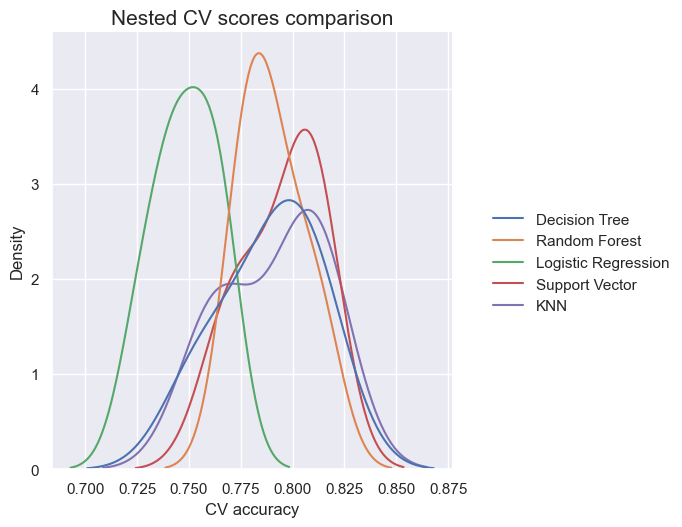

In [25]:
# Plotting histograms of nested CV scores
model_comparison = sns.displot(data=nested_cv_results, kind="kde")
plt.xlabel("CV accuracy")
plt.title("Nested CV scores comparison", fontsize=15)
plt.show()

In [26]:
# Printing mean scores and std of scores
for model, cv_scores in nested_cv_results.items():
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    print(f"{model: <20} {mean_score:.3f} " f"+/- {std_score:.3f}")

Decision Tree        0.789 +/- 0.022
Random Forest        0.790 +/- 0.014
Logistic Regression  0.748 +/- 0.014
Support Vector       0.795 +/- 0.017
KNN                  0.791 +/- 0.022


It can be seen that the nested crossvalidation performance of Support Vector model proves to be better than the rest of the models.

## Choosing hyperparameters of the optimal model

Now that we have identified the optimal model, we should still tune its hyperparameters, since during previous steps we have just determined the model which would a better choice for classifying new, unseen data from the same population. 

Hence, we will choose a larget subset of `C` and `gamma` hyperparameters of the model and will conduct randomized grid search via `RandomizedSearchCV` in order to save time. In this case we will make use of 10-fold crossvalidation, where the algorithm will consider random 50 combinations of various hyperparameters.

In [27]:
%%time

# Specifying hyperparameters to vary
svc_params_grid = OrderedDict()
svc_params_grid["svc__C"] = stats.loguniform(0.0001, 1000.0)
svc_params_grid["svc__gamma"] = stats.loguniform(0.0001, 1000.0)
svc_params_grid["svc__class_weight"] = [None, "balanced"]

# Creating RandomizedSearchCV object
svc_grid_search = RandomizedSearchCV(
    estimator=pipeline_svc,
    param_distributions=svc_params_grid,
    scoring=SCORER,
    cv=10,
    n_iter=50,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Initiating randomized grid search
svc_grid_search.fit(features_train, target_train)

# Printing the accuracy of the best model
print(f"CV {SCORER}: {svc_grid_search.best_score_:.3f}\n")

CV accuracy: 0.803

CPU times: total: 1.52 s
Wall time: 28.9 s


In [28]:
# Printing the hyperparameters of the best model
print(svc_grid_search.best_params_)

{'svc__C': 56.64381243689422, 'svc__class_weight': None, 'svc__gamma': 0.2768415225813714}


In [29]:
# Retrieving the best model from RandomizedSearchCV object
best_model = svc_grid_search.best_estimator_

After grid search procedure, the model managed to reach satisfactory values of CV accuracy but, however, it still needs to be verified on the test dataset.

Lastly, we will plot a learning curve which can help to understand if the model is overfitting (high variance) or underfitting (high bias). This can be done by using two tools built in `sklearn`: 

* `learning_curve`
* `LearningCurveDisplay`

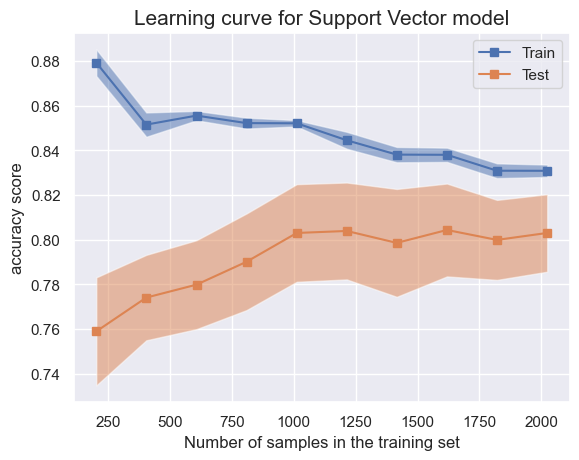

In [30]:
# Determining CV training and test scores for different training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=features_train,
    y=target_train,
    cv=10,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring=SCORER,
)

# Instantiating LCD object
lc_display = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=test_scores,
    score_name=f"{SCORER} score",
)
# Plotting the learning curve
lc_display.plot(line_kw={"marker": "s"})

plt.title("Learning curve for Support Vector model", fontsize=15)
plt.show()

It can be seen that the model does a good job of classifying examples if it has seen more than 1000 examples during training. As the number of training samples grows, the metric slowly improves so it may make sense to add more training examples to the training data. Another solution can be reducing the complexity of the model by increasing the regularization parameter. 

**Conclusion**

After comparing the models, we chose a Support Vector model that outperforms other models in terms of correctly predicting (recommending) the tariff for users.

# Final model tests

## Test set metric

Firstly, we will make sure that the model we selected passes the requirement of the minumum accuracy. 

In [31]:
# Computing predictions on test set
predictions_test = best_model.predict(features_test)

# Computing accuracy on the test set
accuracy_test = accuracy_score(y_true=target_test, y_pred=predictions_test)

# Checking if the model possess the required metrics
assert (
    accuracy_test > ACCURACY_THRESHOLD
), f"Accuracy of the model is less than {ACCURACY_THRESHOLD}"

print(f"Accuracy score (test): {accuracy_test:.3f}")

Accuracy score (test): 0.806


## Sanity check

We will check the adequacy of the final model of Support Vector on a test set. To conduct such an experiment, we must compare the quality of our final model with a static one, that is, a model that will always predict the same class. In this way, we will be able to determine whether the model we trained is adequate and whether its predictions differ significantly from the predictions made by the static model. In this case, in the classification problem, as static predictions we can use a model that recommends the most frequent class in the training set, that is, in this case, the "Smart" tariff (class 0). We can do this by using the `DummyClassifier` from the `dummy` module of the `sklearn` library.

In [32]:
# Instantiating DummyClassifier object
dmb = DummyClassifier(random_state=RANDOM_STATE, strategy="most_frequent")

# Fitting the dummy model to the training data
dmb.fit(features_train, target_train)

# Computing dummy predictions
predictions_dummy = dmb.predict(features_test)

# Computing accuracy of the dummy model
dmb_score = accuracy_score(y_true=target_test, y_pred=predictions_dummy)

# Checking the adequacy of the model
assert accuracy_test > dmb_score, "Model is inadequate"

print(f"Accuracy score (dummy, test): {dmb_score:.3f}")

Accuracy score (dummy, test): 0.693


Using `DummyClassifier`, we generated predictions consisting entirely of zeros, that is, as mentioned above, the random model will always recommend the "Smart" tariff to the client (0 is the most common value in the training set for the target variable). The accuracy turned out to be quite close to 0.7, but our model on the test set shows the value of the quality metric greater than that so our trained model is adequate enough.

**Conclusion**

The use of static predictions led to an underestimation of the quality indicator, which indicates the sanity of the model trained above.

# Final model analysis

Now that the model statisfies all requirements and has passed all tests, we can dig a little deeper into the model itself. For instance, let's compute other possible classification metrics using `classification_report` function from `sklearn.metrics`.

In [33]:
# Names of classes to be printed in the report
target_names = ["Smart", "Ultra"]

# Printing the classification metrics table
print(
    classification_report(
        y_true=target_test, y_pred=predictions_test, target_names=target_names
    )
)

              precision    recall  f1-score   support

       Smart       0.80      0.96      0.87       669
       Ultra       0.83      0.46      0.59       296

    accuracy                           0.81       965
   macro avg       0.82      0.71      0.73       965
weighted avg       0.81      0.81      0.79       965



From this table we can immediately see why it is not really a good idea to use accuracy as metric in imbalanced classification problems. In case of class imbalance, even if the model is a dummy one which always predicts a negative class, the accuracy may reach high values (especially in case of significant class imbalance) and that is a problem. Basically, we have the model that does nothing but still somehow leads to good accuracy results.

Hence, it is better to make use of, for instance, *F1-score* which is robust to class imbalance and combines both *precision* and *recall*. In other words, if *precision* and *recall* are low, then this metric will tend to be low. It is seen here that, in contract to "Smart" users, the model does not do a very good job predicting the "Ultra" tariff (0.87 vs 0.59).

Precision quantifies how many of the total number of clients predicted as "Ultra" clients are actually "Ultra clients". It proves to be that 83% of all clients in the test set were correctly classified as "Ultra" clients. However, that is the value of *recall* metric that affects the value of *F1-score* and brings it to 0.59. As the model shows, only 46% of all "Ultra" clients were labeled as "Ultra" clients. 

These metrics can also be vizualized using two `sklearn` tools:

* `confusion_matrix`
* `ConfusionMatrixDisplay`

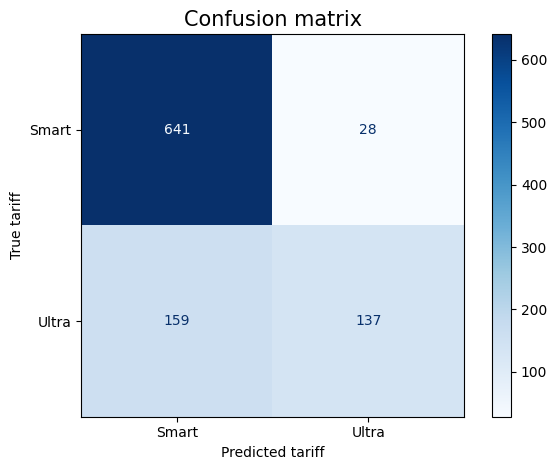

In [34]:
# Reseting the style of plots to a default one
sns.reset_defaults()

# Computing a confusion matrix
cm = confusion_matrix(
    y_true=target_test, y_pred=predictions_test, labels=best_model.classes_
)

# Instantiating CMD object
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names,
)

# Plotting a confusion matrix
cm_display.plot(cmap="Blues")

plt.xlabel("Predicted tariff")
plt.ylabel("True tariff")
plt.title(f"Confusion matrix", fontsize=15)

plt.tight_layout()
plt.show()

We see that the model correcty classified 641 client as those of "Smart" tariff and 137 clients as those having "Ultra" tariff. However, it misclassified 159 clients of "Ultra" tariff as "Smart" and 28 "Smart" clients as "Ultra" clients. All these results assert that it is crucial to choose other metric for model selection, for instance, *F1-score*.

Lastly, let's save the trained model in a separate file using `dump` function from `joblib`.

In [35]:
# Saving the trained model in a file
dump(best_model, "tariff_recomm_model.joblib")

['tariff_recomm_model.joblib']

# General conclusion

Within the framework of this study, the data of customers of a mobile operator were analyzed and a system of tariff recommendation was developed. In particular, data was prepared for five classifiers (Decision Tree, Random Forest, Logistic Regression, Support Vector and KNN), and via the nested 5x2 crossvalidation we managed to selected the best model with the optimal hyperparameter settings.

As a result, the best model from the point of view of the quality metric *accuracy* is Support Vector, which correctly predicts tariffs in about 81% of cases, which is higher than the benchmark level of 75%. Additionally, a sanity check was carried out for the final model, where we generated static predictions of recommending the most frequent tariff and compared them with the quality of the best model. It has been shown that trained model is much better at predicting tariffs than a static model, which shows the adequacy of the final model selected.

However, a further analysis of the model revealed that in fact does not do a very good job predicting the tariff of a client: using *accuracy* metric is incorrect when dealing with imbalanced classes that is the case here.